<a href="https://colab.research.google.com/github/edusporto/mac0417/blob/main/EP3_1_Segmentacao_do_objeto_de_interesse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MAC0417/5768 - Visão e Processamento de Imagens
## 1º semestre de 2021

### Grupo:

* Julia Olsson Rego - 10689460

* Eduardo Sandalo Porto - 11796510

* Elias Kento Tomiyama - 3182204

### Google Drive:

https://drive.google.com/drive/folders/1k6pL_HN4VXwsiBSiIXk0jskFAfDcKR5-?usp=sharing

### Repositório:

https://github.com/edusporto/mac0417


In [ ]:
# pacotes usados neste notebook
import numpy as np
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import skimage
from tqdm.notebook import tqdm
from skimage.filters import threshold_otsu
from skimage.feature import canny
from skimage.morphology import binary_dilation
from scipy import ndimage as ndi
from skimage.util import invert
from skimage import filters
from skimage import feature
from skimage import io
from time import time

In [ ]:
# Usar as imagens armazenadas no Google Drive
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/MAC0417')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ler dataset dos metadados
data = pd.read_csv('metadados.csv')
data = data.sort_values(by=['Fundo','Local','Iluminacao','Classe']) # Organizar dataset
data = data.reset_index(drop=True)

## 3.1 Segmentação

### 3.1.1 Segmentação manual

A segmentação manual foi feita utilizando o software Krita. Para cada classe, foram escolhidas 18 fotos, totalizando assim 180 fotos. Isso representa 16,67% do dataset.

Vamos visualizar as imagens segmentadas manualmente:

In [ ]:
# Ler banco de imagens
dataset_gt = 'segmentacaoManual' # OBS: Não estamos mais usando `BancoImagensMin`
fotos_ground_truth = [f"{dataset_gt}/{img_f}" for img_f in os.listdir(dataset_gt)]
fotos_ground_truth = [img_f for img_f in fotos_ground_truth if '.jpg' in img_f] # apenas guarda imagens

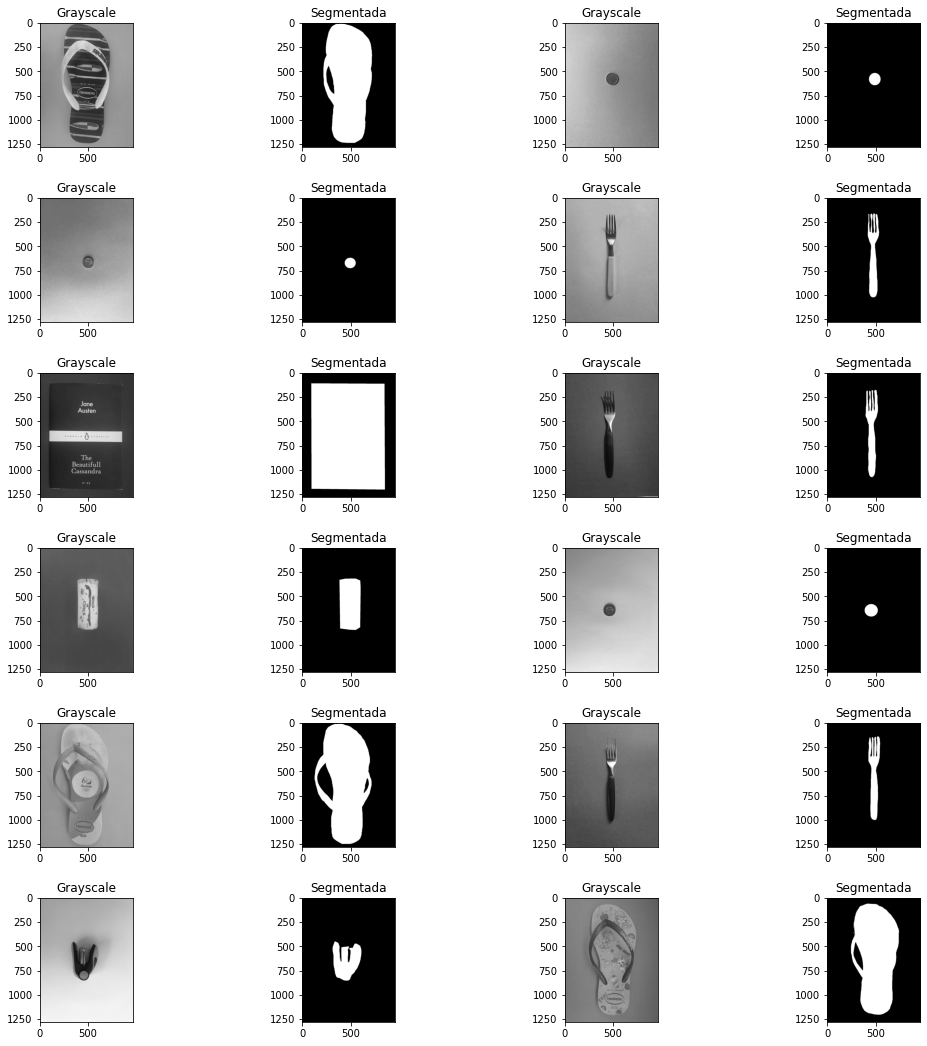

In [ ]:
n_linhas = 6
n_colunas = 4
fig, axs = plt.subplots(n_linhas,n_colunas, figsize=(15,15))
fig.tight_layout(pad=3.0)
for i in range(n_linhas):
  for j in range(0, n_colunas, 2):
    foto_sorteada = random.choice(fotos_ground_truth)
    original_foto_sorteada = foto_sorteada.replace('segmentacaoManual','originalGrayDataset')
    img1 = plt.imread(original_foto_sorteada)
    img2 = plt.imread(foto_sorteada)
    axs[i, j].set_title('Grayscale')
    axs[i, j].imshow(img1, cmap='gray')
    axs[i, j+1].set_title('Segmentada')
    axs[i, j+1].imshow(img2, cmap='gray')

### 3.1.1 Segmentação automática

Utilizamos o **método de Otsu** para fazer a segmentação das imagens.

In [ ]:
print(f"Segmentando as imagens")
t0 = time()

for i in tqdm(range(len(fotos_ground_truth))):
    original_img = fotos_ground_truth[i].replace('segmentacaoManual','originalGrayDataset')
    img = plt.imread(original_img)
    
    # Binarizing image to obtain mask.

    thresh = threshold_otsu(img)
    binary = img > thresh
    avalia = binary[0:20, 0:20]
    pontos = np.sum(avalia < 0.1) 
    if pontos < 300:
        binary = invert(binary)
    fotos_ground_truth_auto = fotos_ground_truth[i].replace('segmentacaoManual','segmentacaoAutomatico')

    # Transforma a imagem de booleanos em uma imagem com pixels de 0 a 255
    binary = binary.astype('uint8')*255

    io.imsave(fotos_ground_truth_auto, binary)

print("feito em %0.3fs" % (time() - t0))

Segmentando as imagens



feito em 73.544s


Vamos ver os resultados para algumas das imagens:

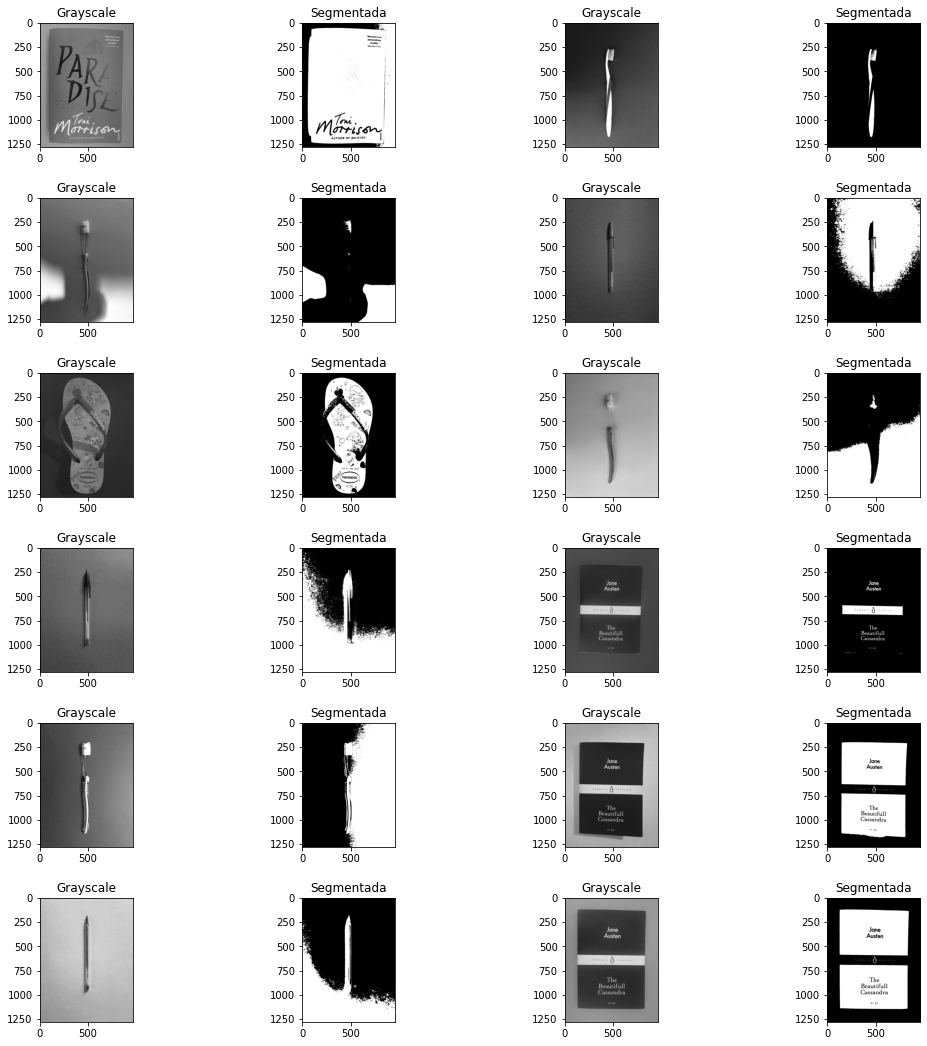

In [ ]:
n_linhas = 6
n_colunas = 4
fig, axs = plt.subplots(n_linhas,n_colunas, figsize=(15,15))
fig.tight_layout(pad=3.0)
for i in range(n_linhas):
  for j in range(0, n_colunas, 2):
    foto_sorteada = random.choice(fotos_ground_truth)
    original_foto_sorteada = foto_sorteada.replace('segmentacaoManual','originalGrayDataset')
    img1 = plt.imread(original_foto_sorteada)
    auto_foto_sorteada = foto_sorteada.replace('segmentacaoManual','segmentacaoAutomatico')
    img2 = plt.imread(auto_foto_sorteada)
    axs[i, j].set_title('Grayscale')
    axs[i, j].imshow(img1, cmap='gray')
    axs[i, j+1].set_title('Segmentada')
    axs[i, j+1].imshow(img2, cmap='gray')

Os resultados não estão satisfatórias para todos os objetos, mas funcionam em alguns casos.

Vamos realizar as métricas para as segmentações automáticas com ground truth.

A métrica utilizada para avaliar segmentação de imagens será o **Dice Coefficient (ou F1)**.

A 

In [ ]:
def dice(img1, img2):
  overlap = 0

  # Transforma as imagens em unidimensionais
  img1_ravel = img1.ravel()
  img2_ravel = img2.ravel()

  for (p1, p2) in zip(img1_ravel, img2_ravel):
    if p1 == p2: overlap += 1
  
  return 2*overlap / (len(img1_ravel) + len(img2_ravel))

In [ ]:
print(f"Avaliando a segmentação de imagens")
t0 = time()

for i in tqdm(range(len(fotos_ground_truth))):
    original_img = fotos_ground_truth[i].replace('segmentacaoManual','originalGrayDataset')
    img = plt.imread(original_img)
    
    # Binarizing image to obtain mask.

    thresh = threshold_otsu(img)
    binary = img > thresh
    avalia = binary[0:20, 0:20]
    pontos = np.sum(avalia < 0.1) 
    if pontos < 300:
        binary = invert(binary)
    fotos_ground_truth_auto = fotos_ground_truth[i].replace('segmentacaoManual','segmentacaoAutomatico')

    # Transforma a imagem de booleanos em uma imagem com pixels de 0 a 255
    binary = binary.astype('uint8')*255


    # Calcula o coeficiente de Dice
    ground_truth = io.imread(fotos_ground_truth[i])
    score = dice(ground_truth, binary)
    # score = np.sum(bin_ravel[img_ravel==255])*2.0 / (np.sum(bin_ravel) + np.sum(img_ravel))
    # score = dice(binary.ravel(), img.ravel())

    print(f"Score da segmentação para {original_img}: {100*score:.2f}%")

Avaliando a segmentação de imagens


Score da segmentação para originalGrayDataset/CanetaAGDiaFora2-gray.jpg: 61.64%
Score da segmentação para originalGrayDataset/CanetaAGNoiteFora3-gray.jpg: 61.25%
Score da segmentação para originalGrayDataset/CanetaARDiaFora1-gray.jpg: 68.05%
Score da segmentação para originalGrayDataset/CanetaARNoiteFora2-gray.jpg: 46.58%
Score da segmentação para originalGrayDataset/CanetaAWNoiteFora1-gray.jpg: 97.95%
Score da segmentação para originalGrayDataset/CanetaBGNoiteDentro3-gray.jpg: 49.59%
Score da segmentação para originalGrayDataset/CanetaBRDiaDentro1-gray.jpg: 54.25%
Score da segmentação para originalGrayDataset/CanetaBRDiaFora3-gray.jpg: 67.36%
Score da segmentação para originalGrayDataset/CanetaBWDiaDentro3-gray.jpg: 98.28%
Score da segmentação para originalGrayDataset/CanetaBWDiaFora3-gray.jpg: 69.60%
Score da segmentação para originalGrayDataset/CanetaCGDiaDentro2-gray.jpg: 39.73%
Score da segmentação para originalGrayDataset/CanetaBRNoiteFora3-gray.jpg: 47.53%
Score da segmentação p

KeyboardInterrupt: ignored

Vamos salvar a segmentação automática para todas as imagens:

In [ ]:
print(f"Segmentando as imagens")
t0 = time()

for i in tqdm(range(len(fotos_ground_truth))):
    original_img = fotos_ground_truth[i].replace('segmentacaoManual','originalGrayDataset')
    img = plt.imread(original_img)
    
    # Binarizing image to obtain mask.

    thresh = threshold_otsu(img)
    binary = img > thresh
    avalia = binary[0:20, 0:20]
    pontos = np.sum(avalia < 0.1) 
    if pontos < 300:
        binary = invert(binary)
    fotos_ground_truth_auto = fotos_ground_truth[i].replace('segmentacaoManual','segmentacaoAutomatico')

    # Transforma a imagem de booleanos em uma imagem com pixels de 0 a 255
    binary = binary.astype('uint8')*255

    io.imsave(fotos_ground_truth_auto, binary)

print("feito em %0.3fs" % (time() - t0))

## Bounding Box / Feret Box

A partir das imagens segmentadas, podemos encontrar os retângulos que cercam a região de interesse, que contêm o objeto. Vamos mostrar um exemplo para o dataset com imagens segmentadas manualmente e um exemplo para o dataset com imagens segmentadas automaticamente.

### Bounding box para uma imagem segmentada manualmente

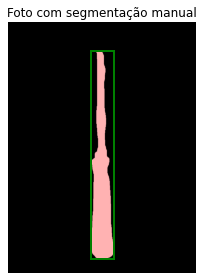

In [ ]:
# Código base disponível em https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import matplotlib.patches as mpatches

img = plt.imread('segmentacaoManual/FendaCGNoiteDentro2-gray.jpg')
# Aplicar threshold
thresh = threshold_otsu(img)
bw = closing(img > thresh, square(3))

# Remover ruídos da borda
cleared = clear_border(bw)

# Regiões da imagem
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=img, bg_label=0)
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(image_label_overlay)
ax.set_title('Foto com segmentação manual')
for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

### Bounding box para uma imagem segmentada automaticamente

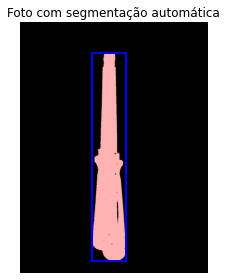

In [ ]:
# Código base disponível em https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html

img = plt.imread('./segmentacaoAutomatico/FendaCGNoiteDentro2-gray.jpg')
# Aplicar threshold
thresh = threshold_otsu(img)
bw = closing(img > thresh, square(3))

# Remover ruídos da borda
cleared = clear_border(bw)

# Regiões da imagem
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=img, bg_label=0)
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(image_label_overlay)
ax.set_title('Foto com segmentação automática')
for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='blue', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

Nos testes feitos com as fotos com segmentação manual, a rotina de Bounding Box implementa teve bons resultados. O mesmo não foi observado para as fotos com segmentação automática.